In [5]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [15]:
def load_plot(page, VERSION=VERSION, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [19]:
PROPHET_PATH = '../data/prophet/'
CACHE_PATH = 'cache/'
RESULTS_PATH = 'results/'
VERSION ='v7.1t/'
CVERSION ='v7t/'
YVERSION ='v7ty/'

In [20]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [21]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

page_index                                               Page  \
0           0            2NE1_zh.wikipedia.org_all-access_spider   
1           1             2PM_zh.wikipedia.org_all-access_spider   
2           2              3C_zh.wikipedia.org_all-access_spider   
3           3         4minute_zh.wikipedia.org_all-access_spider   
4           4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...   

   median_pred_60  median_pred_120  prevYear_median_pred_60  \
0              24               23                       16   
1              24               22                       14   
2               3                3                        4   
3              15               19                       14   
4              14               14                        3   

   prevYear_median_pred_120  smape_60_to_0  smape_120_to_60  \
0                        17      32.278432        25.959053   
1                        17      42.847863        34.415304   
2                         6      64.305367        65.870407   
3                        14      32.250349        33.896551   
4                         5      48.547274        38.718059   

   prevYear_smape_60_to_0  prevYear_smape_120_to_60  nans_start_to_120  \
0               40.870388                 32.116348                  0   
1               60.431899                 32.054860                  0   
2               47.163640                 56.748585                  0   
3               35.401843                 49.278494                  0   
4               54.426324                 57.220372                291   

   nans_120_to_60  nans_60_to_0  prevYear_nans_60_to_0  \
0               0             0                      0   
1               0             0                      0   
2               0             0                      0   
3               0             0                      0   
4               0             0                      0   

   prevYear_nans_120_to_60  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

In [11]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

29.5085214082
(34, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
page_index     34 non-null int64
v7.1t_train    34 non-null float64
v7.1t_val      34 non-null float64
dtypes: float64(2), int64(1)
memory usage: 896.0 bytes
None
126.761619995


page_index  v7.1t_train   v7.1t_val
0        5712    48.161938  128.418219
1        6244    29.810772  186.684901
2        6337    18.810967   34.733478
3        6682    18.383431   77.825848
4        7117    24.770400  168.192600

In [22]:
ctest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+CVERSION[:-1]+'df.f'); 
ctest_df.page_index = ctest_df.page_index.astype(int)
print(ctest_df[CVERSION[:-1]+'_train'].mean())
ctest_df = ctest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#ctest_df = ctest_df.drop(CVERSION[:-1]+'_train', axis=1)
print(ctest_df.shape)
print(ctest_df.info())
print(ctest_df[CVERSION[:-1]+'_val'].mean())
ctest_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


page_index  v7t_train     v7t_val
0           0  46.736751   32.642601
1           1  48.666767   83.565553
2           2  69.758611  120.451293
3           3  45.255355   38.493515
4           4  66.002965   89.498846

In [23]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


page_index  v7ty_train    v7ty_val
0           0   47.323987   44.956479
1           1   48.262866   61.287282
2           2   71.127792   58.073251
3           3   46.191346   52.285567
4           4   62.962499  132.877882

In [25]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(ctest_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()
df['ctest_gain'] = df.smape_60_to_0 - df[CVERSION[:-1]+'_val']; df.head()

(34, 5)
(34, 7)
(34, 21)


page_index  v7ty_train   v7ty_val  v7.1t_train   v7.1t_val  v7t_train  \
0        5712   44.416800  99.276372    48.161938  128.418219  48.184878   
1        6244   26.159549  74.039647    29.810772  186.684901  29.480145   
2        6337   18.277288  38.908619    18.810967   34.733478  18.767376   
3        6682   17.172334  23.665158    18.383431   77.825848  17.299133   
4        7117   21.945877  63.753827    24.770400  168.192600  24.936676   

      v7t_val                                               Page  \
0  125.466577           Pont_fr.wikipedia.org_desktop_all-agents   
1  197.331147  Antigone_(Anouilh)_fr.wikipedia.org_desktop_al...   
2  157.860327  Civilisation_maya_fr.wikipedia.org_desktop_all...   
3  192.165023  Loi_1_du_football_fr.wikipedia.org_desktop_all...   
4  191.423368  Le_Bourgeois_gentilhomme_fr.wikipedia.org_desk...   

   median_pred_60  median_pred_120     ...      prevYear_smape_60_to_0  \
0             310              370     ...                  125.518731   
1             564              728     ...                  151.611885   
2             323              503     ...                   67.846841   
3             198              248     ...                   49.524930   
4             192              510     ...                  118.186818   

   prevYear_smape_120_to_60  nans_start_to_120  nans_120_to_60  nans_60_to_0  \
0                 68.806359                  0               0             0   
1                 51.246652                  0               0             0   
2                 39.117126                  0               0             0   
3                 35.068657                  0               0             0   
4                 63.726171                  0               0             0   

   prevYear_nans_60_to_0  prevYear_nans_120_to_60  Ytest_gain  test_gain  \
0                      0                        0   16.573609 -12.568237   
1                      0                        0   61.002735 -51.642518   
2                      0                        0   13.553392  17.728533   
3                      0                        0    7.742603 -46.418087   
4                      0                        0   33.764315 -70.674458   

   ctest_gain  
0   -9.616596  
1  -62.288765  
2 -105.398316  
3 -160.757262  
4  -93.905227  

[5 rows x 24 columns]

In [29]:
df['gain_from_new_version'] =df['test_gain'] -  df['ctest_gain']

In [29]:
(df['test_gain'] -  df['ctest_gain'])

In [31]:
df['gain_from_new_version'].mean()

46.544020918010403

In [32]:
# worst
for row in df.sort_values(
    by='gain_from_new_version', ascending=True).iloc[0:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [11]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [12]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0         NaN   59.292576   47.521198   42.279365   43.644768   45.184539   
1         NaN   73.260387   69.616005   67.684029   68.770630   69.095268   
2         NaN   99.293651  180.000000   99.626984  101.293651  100.341270   
3         NaN   88.967936   70.416485   56.959173   69.960825   55.197029   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10     ...      2017-08-22  \
0   43.202023   41.268254   42.592001   44.607579     ...             NaN   
1   70.576750   71.639287   71.655954   74.052468     ...             NaN   
2  100.722222   99.388889   99.388889   99.055556     ...             NaN   
3   60.669316   53.567910   52.966730   54.192555     ...             NaN   
4         NaN         NaN         NaN         NaN     ...             NaN   

   2017-08-23  2017-08-24  2017-08-25  2017-08-26  2017-08-27  2017-08-28  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2017-08-29  2017-08-30  2017-08-31  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 793 columns]

In [13]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=True)

prophet_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum() -> 145063


In [14]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


2015-08-30  2015-08-31  2015-09-01  2015-09-02  2015-09-03  2015-09-04  \
0    46.01400    45.40289    45.30144    44.52684    45.14765    45.53654   
1    53.50449    53.26103    53.13358    52.39626    52.15095    51.44100   
2    71.58922    71.25588    72.57456    72.46874    72.02430    72.02430   
3    53.84082    54.01158    53.71279    52.48091    52.18176    52.27033   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-09-05  2015-09-06  2015-09-07  2015-09-08     ...      2017-08-22  \
0    46.25179    46.21211    46.71445    45.58791     ...             NaN   
1    50.79423    51.01956    52.92075    53.88034     ...             NaN   
2    71.74652    72.80472    72.63806    72.16187     ...             NaN   
3    52.99497    52.96078    53.43351    53.60186     ...             NaN   
4         NaN         NaN         NaN         NaN     ...             NaN   

   2017-08-23  2017-08-24  2017-08-25  2017-08-26  2017-08-27  2017-08-28  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2017-08-29  2017-08-30  2017-08-31  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 733 columns]

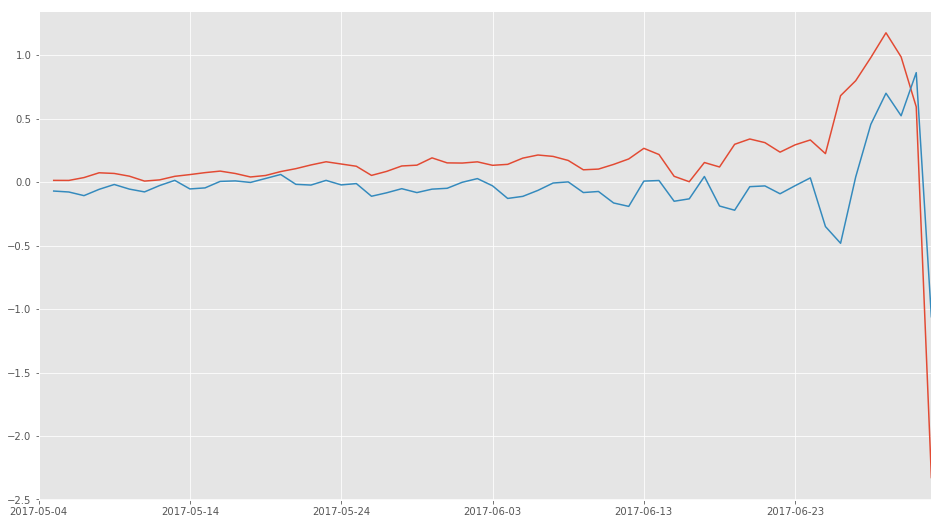

In [15]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

In [16]:
# remove the yhat smape for the t
yhat_rolling_smape2 = yhat_rolling_smape.copy()
#yhat_rolling_smape2.iloc[:,-120:] = np.nan

In [17]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape2.iloc[:,:cut_off]).std(axis=1)

In [18]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


In [19]:
df.head()

page_index  v7ty_train    v7ty_val  v7t_train     v7t_val  \
0           0   47.323987   44.956479  46.736751   32.642601   
1           1   48.262866   61.287282  48.666767   83.565553   
2           2   71.127792   58.073251  69.758611  120.451293   
3           3   46.191346   52.285567  45.255355   38.493515   
4           4   62.962499  132.877882  66.002965   89.498846   

                                                Page  median_pred_60  \
0            2NE1_zh.wikipedia.org_all-access_spider              24   
1             2PM_zh.wikipedia.org_all-access_spider              24   
2              3C_zh.wikipedia.org_all-access_spider               3   
3         4minute_zh.wikipedia.org_all-access_spider              15   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...              14   

   median_pred_120  prevYear_median_pred_60  prevYear_median_pred_120  \
0               23                       16                        17   
1               22                       14                        17   
2                3                        4                         6   
3               19                       14                        14   
4               14                        3                         5   

         ...         prevYear_smape_120_to_60  nans_start_to_120  \
0        ...                        32.116348                  0   
1        ...                        32.054860                  0   
2        ...                        56.748585                  0   
3        ...                        49.278494                  0   
4        ...                        57.220372                291   

   nans_120_to_60  nans_60_to_0  prevYear_nans_60_to_0  \
0               0             0                      0   
1               0             0                      0   
2               0             0                      0   
3               0             0                      0   
4               0             0                      0   

   prevYear_nans_120_to_60  Ytest_gain  test_gain  rolling_gain_mean  \
0                        0  -12.678048  -0.364169          -4.586877   
1                        0  -18.439419 -40.717689          -5.471587   
2                        0    6.232116 -56.145926         -11.048583   
3                        0  -20.035218  -6.243166          -2.399449   
4                        0  -84.330608 -40.951572          11.684981   

   rolling_gain_std  
0          7.105016  
1          6.573979  
2         13.843225  
3          6.971026  
4         33.645347  

[5 rows x 23 columns]

In [20]:
df[['rolling_gain_mean','test_gain','rolling_gain_std']].corr()

rolling_gain_mean  test_gain  rolling_gain_std
rolling_gain_mean           1.000000   0.568253         -0.321331
test_gain                   0.568253   1.000000         -0.565914
rolling_gain_std           -0.321331  -0.565914          1.000000

# Feature Testing Area

In [21]:
yhat = wiki.newphet.load_prophet_prop(VERSION, 'yhat')
trend = wiki.newphet.load_prophet_prop(VERSION, 'trend')

In [23]:
yhat_org = wiki.newphet.load_prophet_prop(VERSION, 'yhat_org')

100%|██████████| 145063/145063 [07:29<00:00, 322.77it/s]


In [89]:
df['yhat_org_mean'] = yhat_org.iloc[:,-60:].mean(axis=1)

In [131]:
df['yhat_median'] = yhat.iloc[:,-60:].median(axis=1)

# Filter Testing

In [105]:
#BASE_SCORE = df.smape_60_to_0.mean()

In [106]:
BASE_SCORE

41.043204039840212

In [107]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0)
             )
print(len(df[filter_df]))

6673


In [33]:
len(pd.read_feather('../data/prophet/results/proph_v7_preds.f'))

6520

In [108]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

40.834855883471157

In [109]:
filter_df2 = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0) &
             ~(df['yhat_org_mean'] < 0)
             )
print(len(df[filter_df2]))

6637


In [110]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

40.819341831834556

In [ ]:
#bad_yhat_org.

In [139]:
filter_df3 = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0) &
              ~(df['yhat_median']*2 < df.median_pred_60 ) &
             ~(df['yhat_org_mean'] < 0)
             )
print(len(df[filter_df3]))

6023


In [140]:
pd.concat([df[filter_df3].v7t_val,
           df[~filter_df3].smape_60_to_0]).mean()
#40.79419791496953 (without the )

40.794199583018852

# Investigation of series

In [144]:
df[(~filter_df3) & (df.test_gain > 0)].sort_values(by='test_gain',ascending=False)

page_index  v7ty_train    v7ty_val   v7t_train     v7t_val  \
78992        78992   63.767386  138.461538   70.959804    0.000000   
23326        23326   51.798972  200.000000   53.564078    0.000000   
79227        79227  170.788199         NaN  170.788199    0.000000   
79712        79712   66.838763  189.764130   86.822124    0.000000   
78015        78015  141.884475         NaN  141.884475    0.000000   
78462        78462  148.496510  196.393498  156.920724   20.000000   
79236        79236  106.687568  152.656351  114.111309   16.666667   
21678        21678   88.223423   58.790057   84.635875   51.568783   
122358      122358   30.380621   21.426579   33.919607   27.647838   
56504        56504   21.718383   13.208015   23.128950   18.036305   
59259        59259   39.042708   23.874687   48.000523   31.468059   
124992      124992   81.091889   73.421829   74.866158   64.773332   
78032        78032  102.039444  136.249940  104.250140   35.294118   
22763        22763   42.094732    0.000000   44.086316   33.333333   
77755        77755  120.106947  111.529233  119.017749   33.333333   
22294        22294   67.880422  113.396923   72.733734   66.666667   
23115        23115   44.402208         NaN   44.402208   33.333333   
119529      119529   16.490845   12.862344   16.320174   20.961182   
22067        22067   52.509389   66.666667   53.923418   36.363636   
22073        22073   44.746191  200.000000   42.443067   36.363636   
22889        22889   61.983255  159.575532   68.783523   74.074074   
51332        51332  111.899227   78.033725  109.542434   40.797658   
132771      132771   29.929328  142.067558   48.575324   23.057908   
78035        78035  113.175999  163.642272  102.839296   40.000000   
52276        52276  117.366820   79.090956  116.799601   49.810943   
38703        38703   39.319342   66.913347   38.681513   38.328004   
26201        26201  108.709630   74.618725  107.135502   47.733521   
53339        53339  117.336770   81.917137  118.132139   45.781878   
21230        21230   49.966561         NaN   49.966561   83.703704   
79300        79300   69.127996   90.264984   85.695274   55.259502   
...            ...         ...         ...         ...         ...   
109842      109842   14.140854   18.941600   14.116119   12.656585   
264            264   51.149528   47.542051   50.601032   48.285560   
127881      127881   75.970759   69.118466   73.199863   87.165210   
82403        82403    8.692427   10.228637    8.755106    9.880972   
60194        60194   27.409691   29.666024   26.199010   37.798613   
10759        10759   77.444512         NaN   77.444512  199.990088   
13355        13355   59.127170   60.006013   58.549390   62.611889   
144827      144827   44.392116  144.185088   44.007280   78.771709   
81660        81660    8.977846   16.750142    9.063589   14.108712   
5963          5963   21.007901   45.461042   21.779055   24.840508   
33457        33457   64.923368  138.049303   66.563493   35.684486   
143298      143298   55.617482   54.533355   55.103845   38.034617   
112897      112897   43.587348   43.305278   43.885337   52.062480   
113561      113561   45.211059   43.338180   45.224867   48.246622   
73242        73242   24.699007   37.919464   29.187618   42.115804   
1373          1373   38.205289   47.483824   37.006816   38.794124   
138142      138142    9.901316    9.971979    9.800859   26.205340   
80552        80552    8.595591    7.971778    8.525149    9.846541   
19295        19295   11.600235   10.192546   11.251989   12.298487   
32139        32139   80.110571         NaN   80.110571  183.755936   
16789        16789   21.863606   46.979305   21.136288   19.182142   
42227        42227   20.195919   22.166105   20.439505   17.136279   
644            644   38.993600   38.895792   39.707576   34.775706   
36882        36882   34.673292   30.656781   33.561063   30.768746   
15919        15919    6.302792   13.651483    6.293099    6.638909   
34300        34300

In [116]:
bad_yhat_org = df[~((pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).sort_index() == pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).sort_index()))].dropna(subset=['v7t_val'])
# 173.30564091343655
# and with dropna it's the same, and get 34 of them when dropna so all good

In [151]:
bad_yhat_org[['page_index']].reset_index(drop=True).to_feather(PROPHET_PATH+CACHE_PATH+'yhat_org_mean_LESS_0.f')

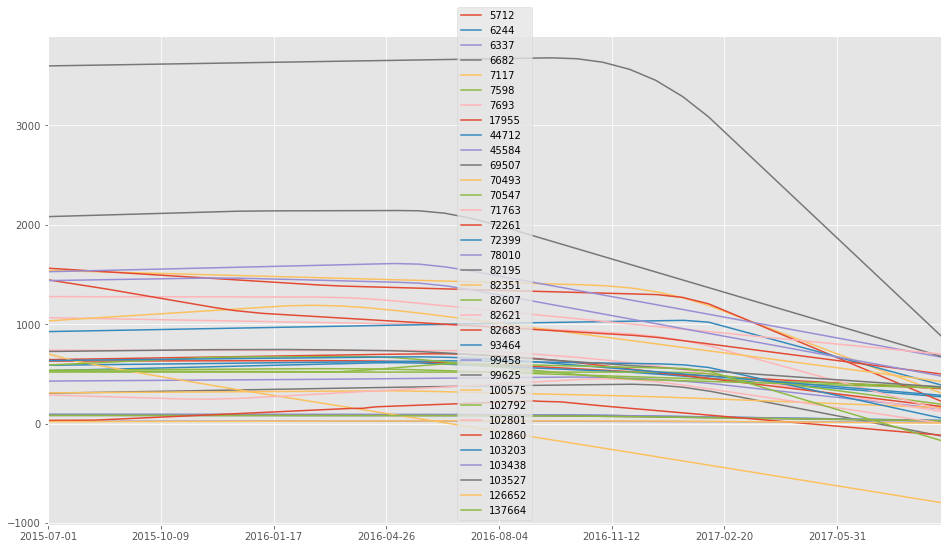

In [126]:
trend[trend.index.isin(bad_yhat_org.index)].T.plot()

# Plotting best and worst

page_index                                                              10970
v7ty_train                                                            9.99599
v7ty_val                                                              13.3505
v7t_train                                                             9.81377
v7t_val                                                               102.198
Page                        Alice's_Adventures_in_Wonderland_en.wikipedia....
median_pred_60                                                           1882
median_pred_120                                                          2066
prevYear_median_pred_60                                                  2982
prevYear_median_pred_120                                                 2483
smape_60_to_0                                                         25.4216
smape_120_to_60                                                          30.3
prevYear_smape_60_to_0                                          

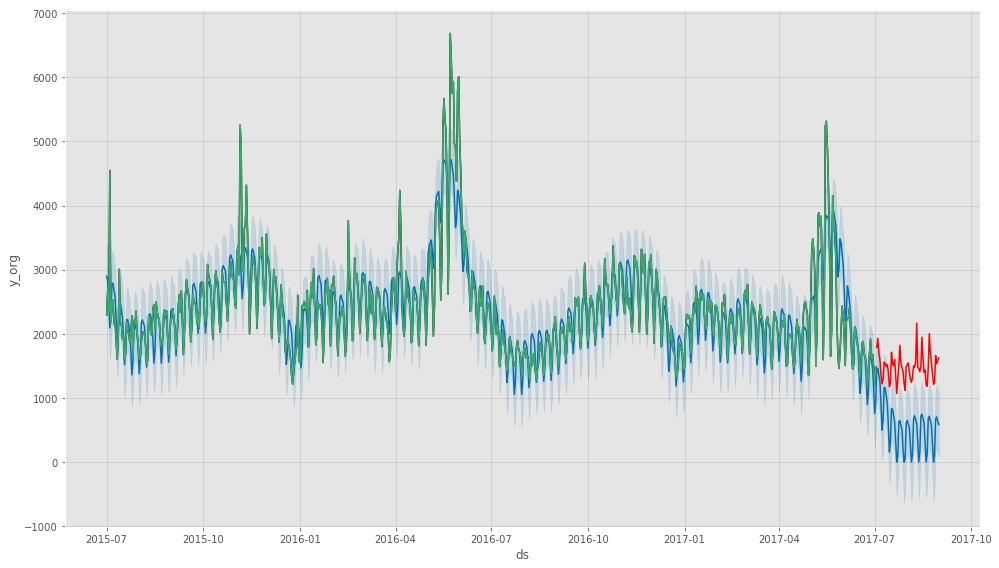

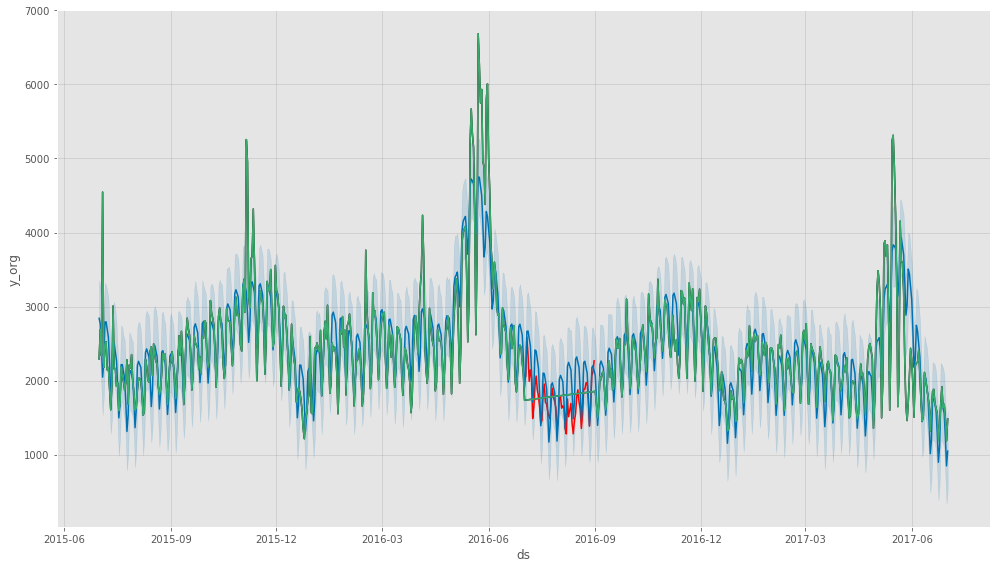

page_index                                                              66029
v7ty_train                                                            16.2512
v7ty_val                                                              26.5481
v7t_train                                                             16.5039
v7t_val                                                               116.996
Page                        Konzentrationslager_de.wikipedia.org_desktop_a...
median_pred_60                                                            559
median_pred_120                                                           579
prevYear_median_pred_60                                                   798
prevYear_median_pred_120                                                  713
smape_60_to_0                                                         40.7891
smape_120_to_60                                                       19.7357
prevYear_smape_60_to_0                                          

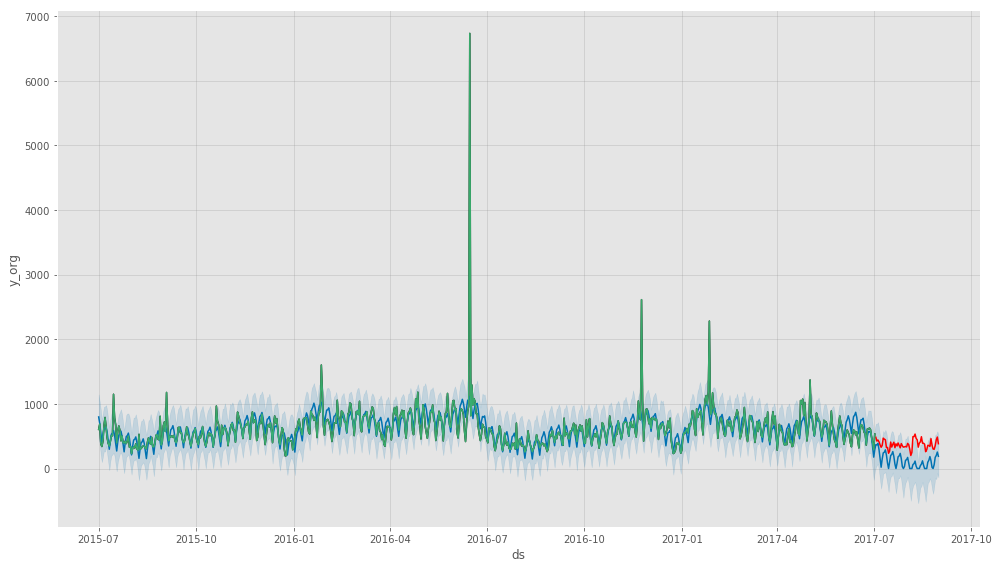

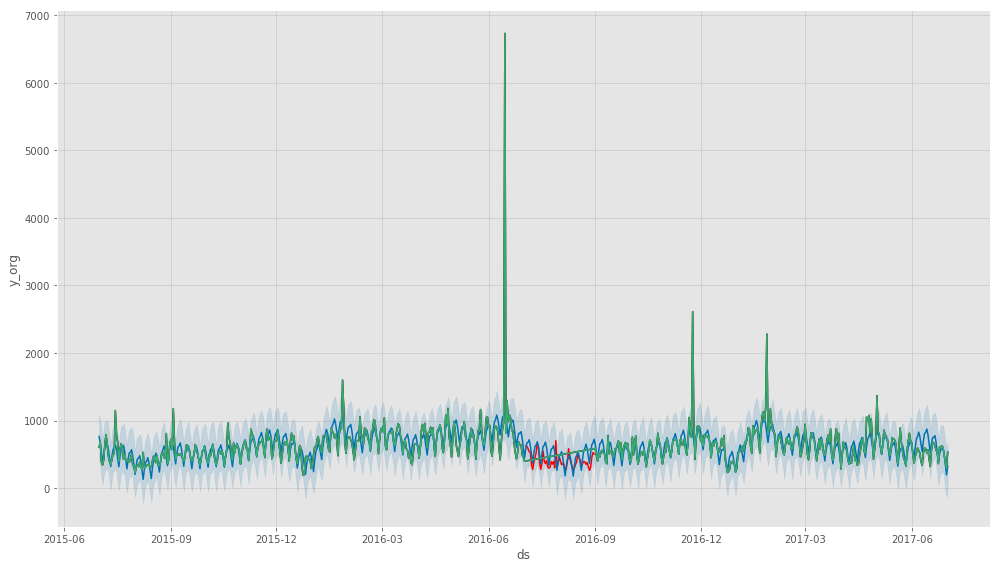

page_index                                                              71048
v7ty_train                                                            22.6312
v7ty_val                                                               36.122
v7t_train                                                             22.2522
v7t_val                                                               127.162
Page                        Ley_de_Coulomb_es.wikipedia.org_desktop_all-ag...
median_pred_60                                                            812
median_pred_120                                                           851
prevYear_median_pred_60                                                  1374
prevYear_median_pred_120                                                 1439
smape_60_to_0                                                         51.9019
smape_120_to_60                                                       26.2992
prevYear_smape_60_to_0                                          

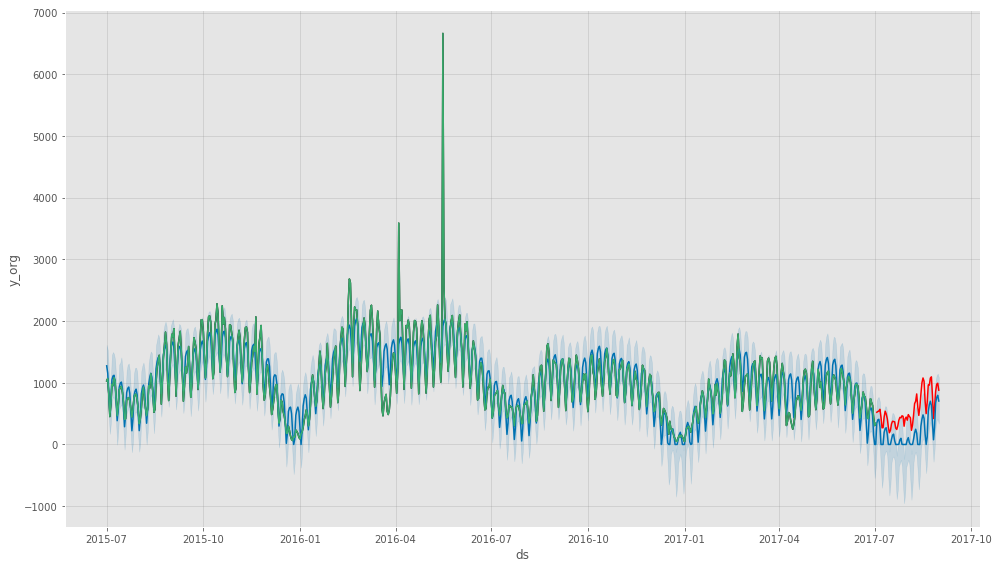

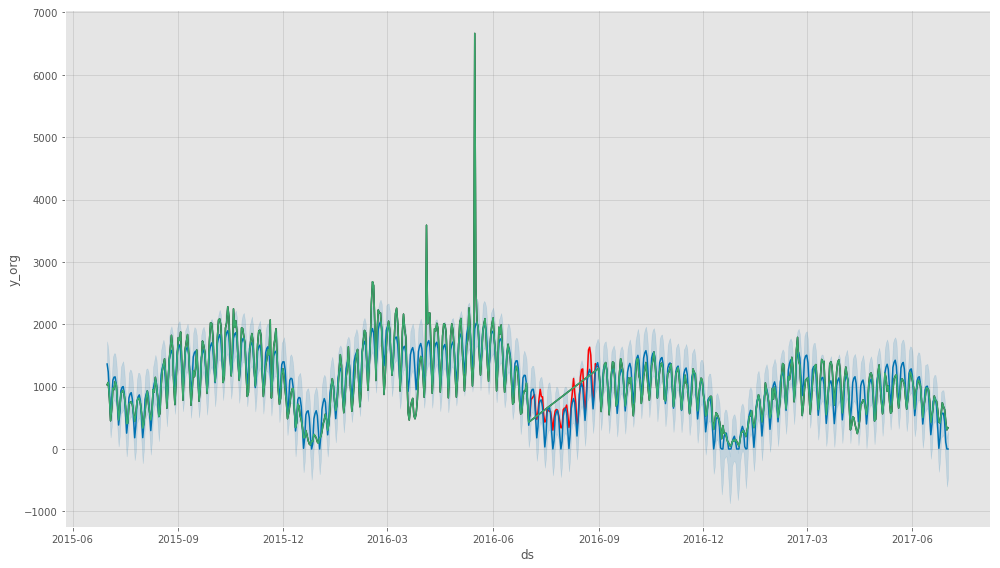

page_index                                                              70355
v7ty_train                                                             19.629
v7ty_val                                                              15.6519
v7t_train                                                             19.0448
v7t_val                                                               90.2024
Page                        Michael_Fassbender_es.wikipedia.org_desktop_al...
median_pred_60                                                            422
median_pred_120                                                           526
prevYear_median_pred_60                                                   967
prevYear_median_pred_120                                                  570
smape_60_to_0                                                         15.8619
smape_120_to_60                                                       37.3745
prevYear_smape_60_to_0                                          

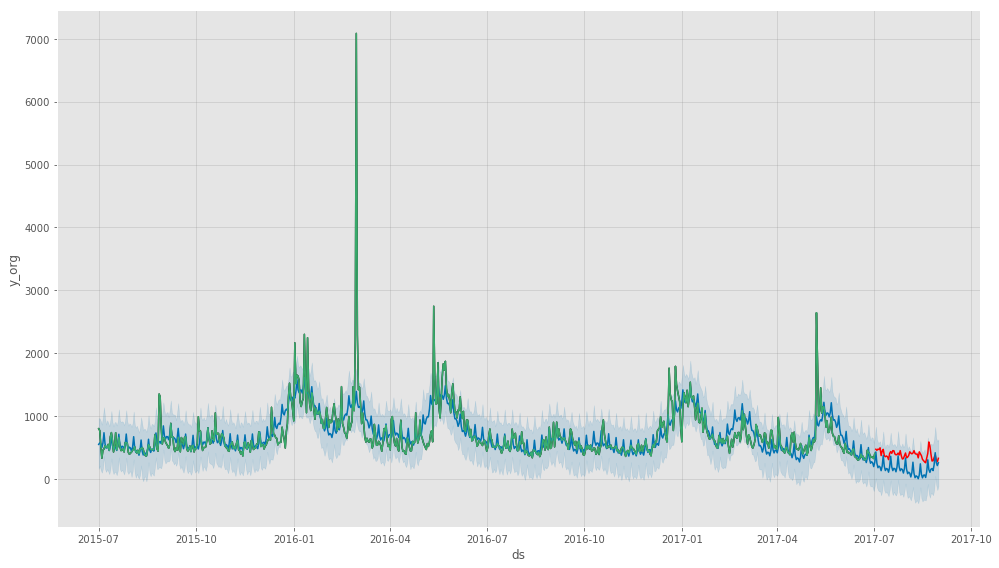

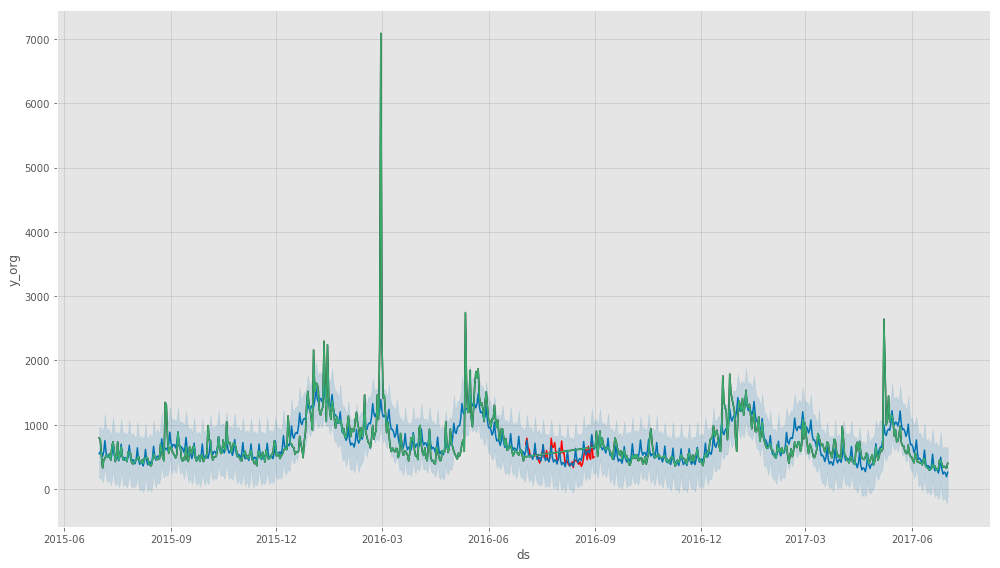

page_index                                                            70044
v7ty_train                                                          13.2887
v7ty_val                                                            13.5589
v7t_train                                                           13.5806
v7t_val                                                             96.2508
Page                        Groenlandia_es.wikipedia.org_desktop_all-agents
median_pred_60                                                          721
median_pred_120                                                         847
prevYear_median_pred_60                                                1091
prevYear_median_pred_120                                               1095
smape_60_to_0                                                       22.0253
smape_120_to_60                                                     21.2983
prevYear_smape_60_to_0                                              29.4429
prevYear_sma

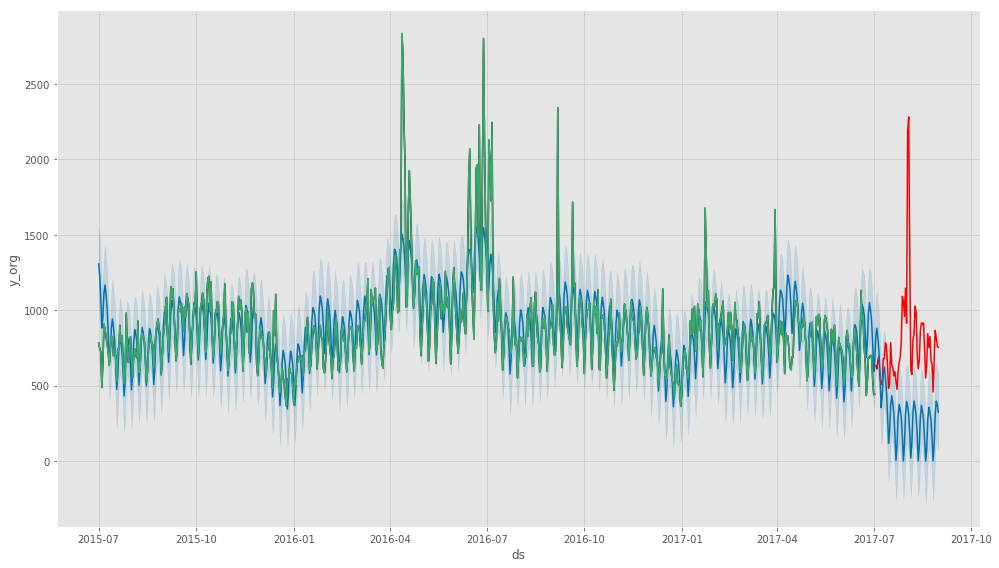

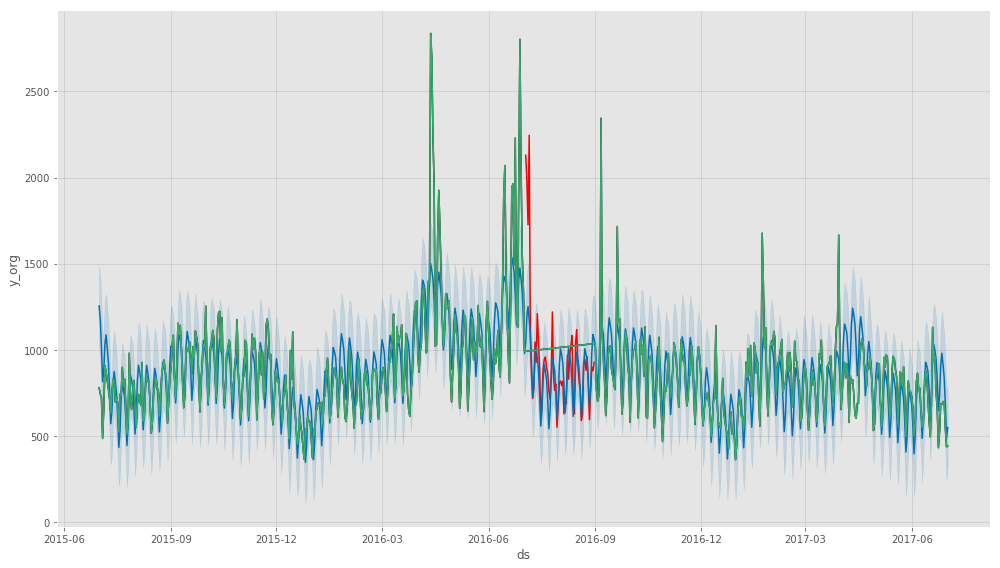

page_index                                                              95788
v7ty_train                                                            20.6221
v7ty_val                                                              18.6125
v7t_train                                                             20.1892
v7t_val                                                               98.4821
Page                        Scarlett_Johansson_es.wikipedia.org_mobile-web...
median_pred_60                                                           2147
median_pred_120                                                          3347
prevYear_median_pred_60                                                  2840
prevYear_median_pred_120                                                 3135
smape_60_to_0                                                         25.1771
smape_120_to_60                                                        41.451
prevYear_smape_60_to_0                                          

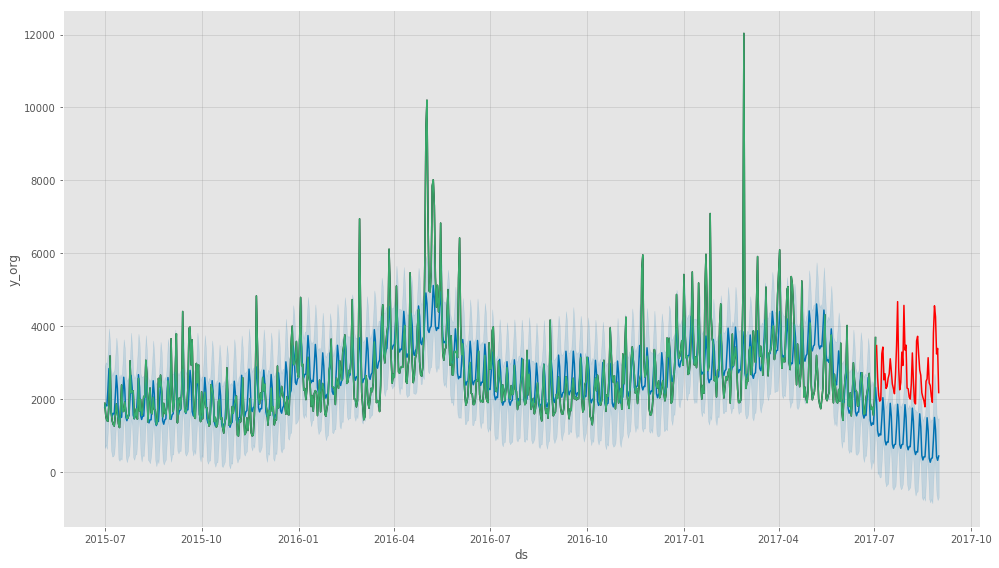

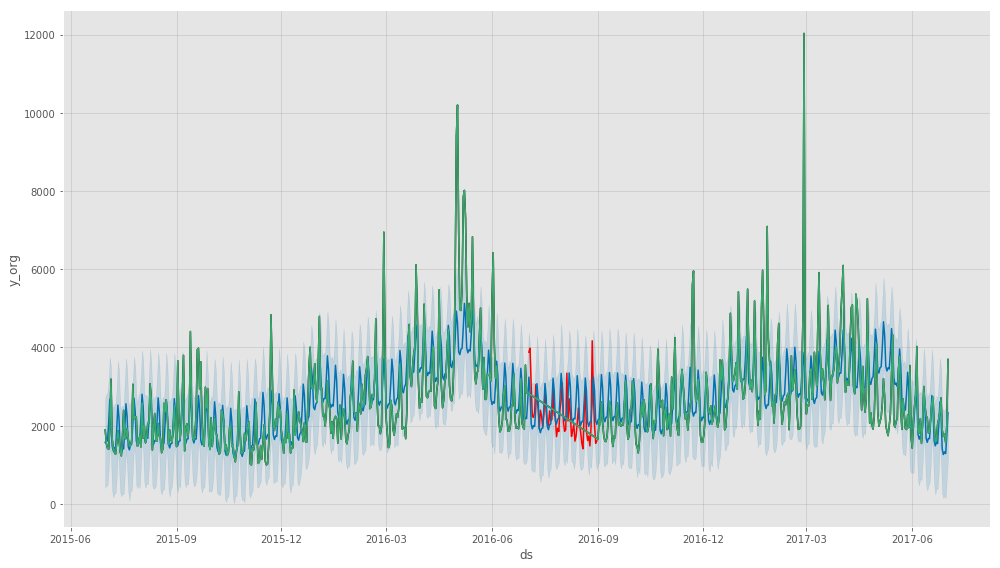

page_index                                                             72256
v7ty_train                                                           20.0682
v7ty_val                                                             22.7069
v7t_train                                                            19.5302
v7t_val                                                              114.386
Page                        Miguel_Ángel_es.wikipedia.org_desktop_all-agents
median_pred_60                                                          1637
median_pred_120                                                         1669
prevYear_median_pred_60                                                 1812
prevYear_median_pred_120                                                2154
smape_60_to_0                                                        42.7467
smape_120_to_60                                                      29.6444
prevYear_smape_60_to_0                                               47.7475

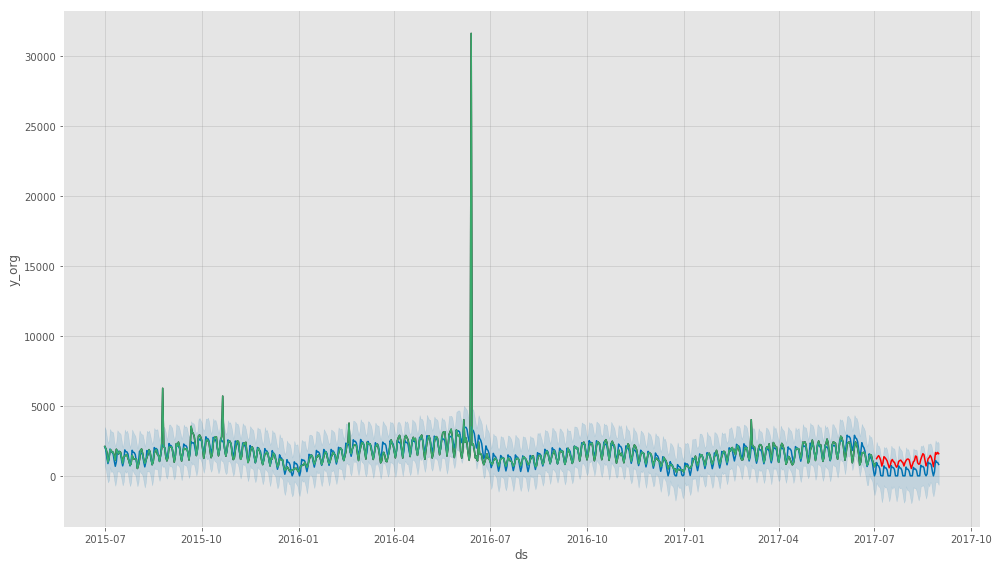

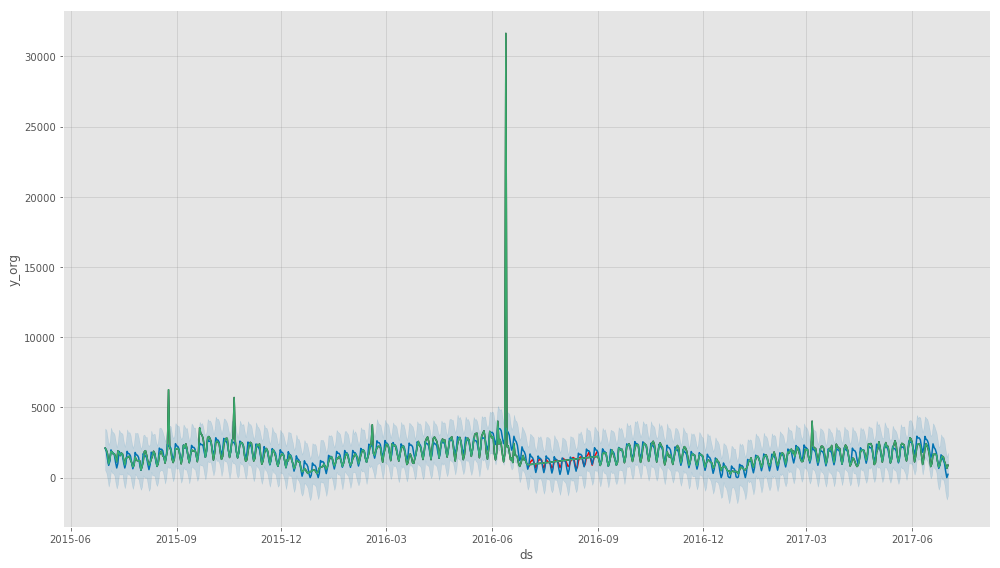

page_index                                                             102246
v7ty_train                                                            24.6541
v7ty_val                                                              51.0643
v7t_train                                                             24.7778
v7t_val                                                               131.251
Page                        Битва_за_Москву_ru.wikipedia.org_desktop_all-a...
median_pred_60                                                            599
median_pred_120                                                           958
prevYear_median_pred_60                                                   657
prevYear_median_pred_120                                                 1092
smape_60_to_0                                                         59.7333
smape_120_to_60                                                        48.607
prevYear_smape_60_to_0                                          

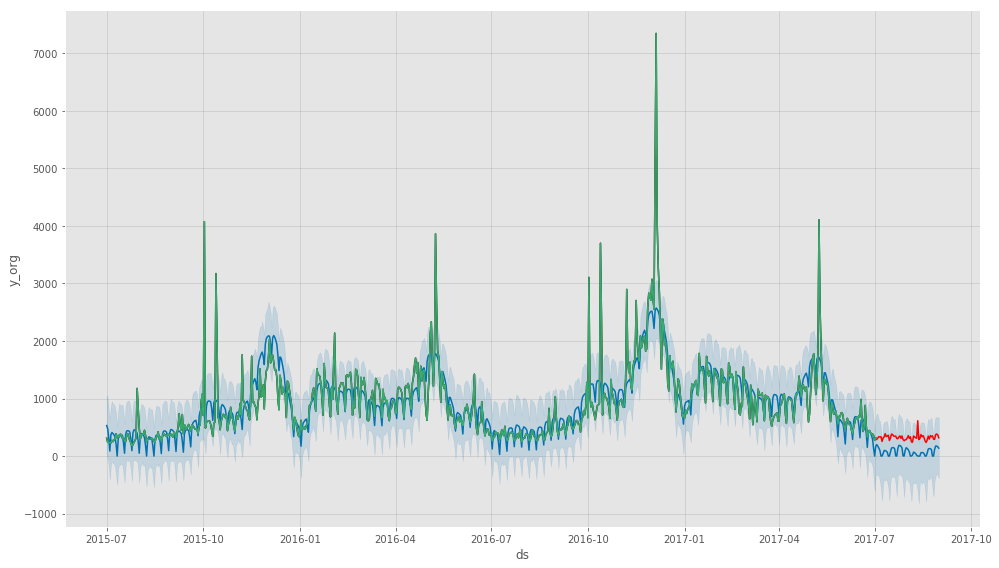

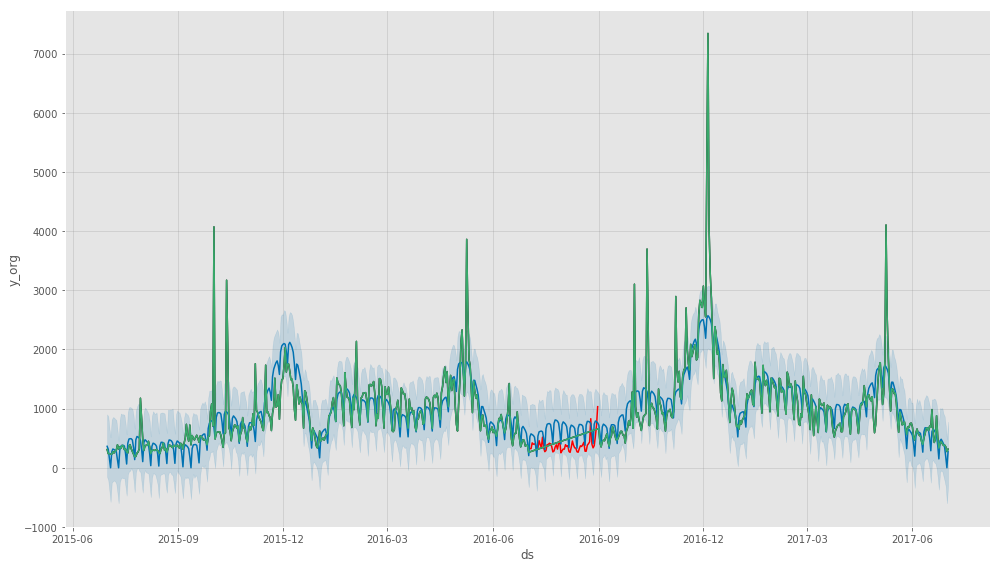

page_index                                                        71512
v7ty_train                                                      16.6403
v7ty_val                                                        21.8728
v7t_train                                                       16.1739
v7t_val                                                         100.186
Page                        Corazón_es.wikipedia.org_desktop_all-agents
median_pred_60                                                     1328
median_pred_120                                                    1253
prevYear_median_pred_60                                            2206
prevYear_median_pred_120                                           2117
smape_60_to_0                                                   28.9177
smape_120_to_60                                                 23.9191
prevYear_smape_60_to_0                                          34.6515
prevYear_smape_120_to_60                                        

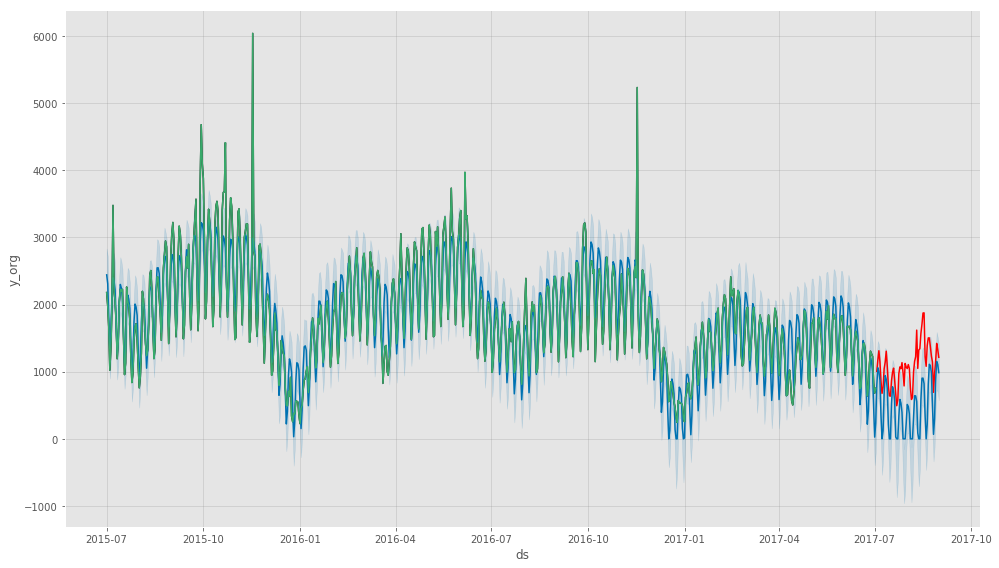

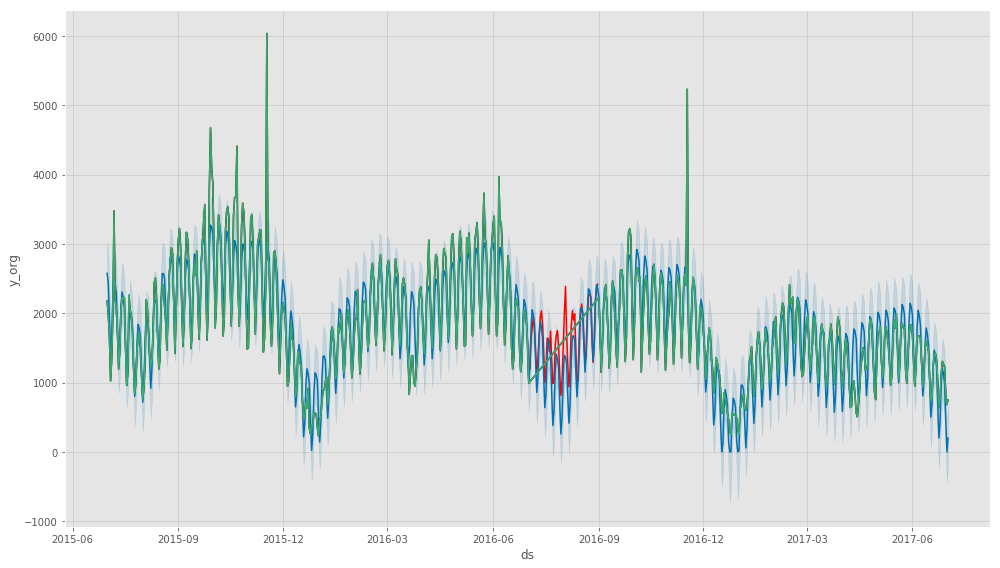

page_index                                                            92729
v7ty_train                                                          20.9387
v7ty_val                                                            31.2053
v7t_train                                                           20.7908
v7t_val                                                             110.316
Page                        Electrón_es.wikipedia.org_all-access_all-agents
median_pred_60                                                         1947
median_pred_120                                                        2420
prevYear_median_pred_60                                                2531
prevYear_median_pred_120                                               3406
smape_60_to_0                                                       39.1612
smape_120_to_60                                                       28.91
prevYear_smape_60_to_0                                              50.1153
prevYear_sma

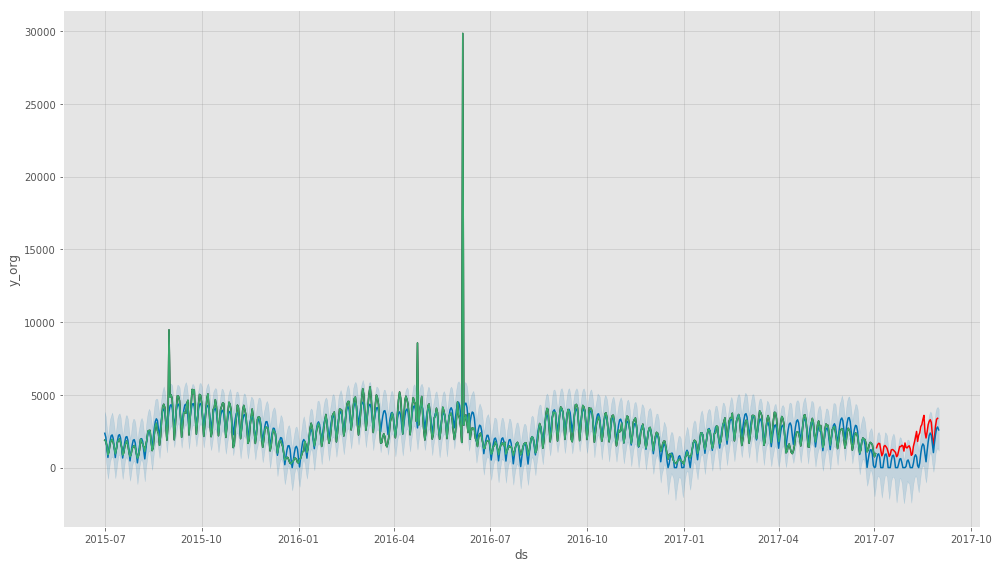

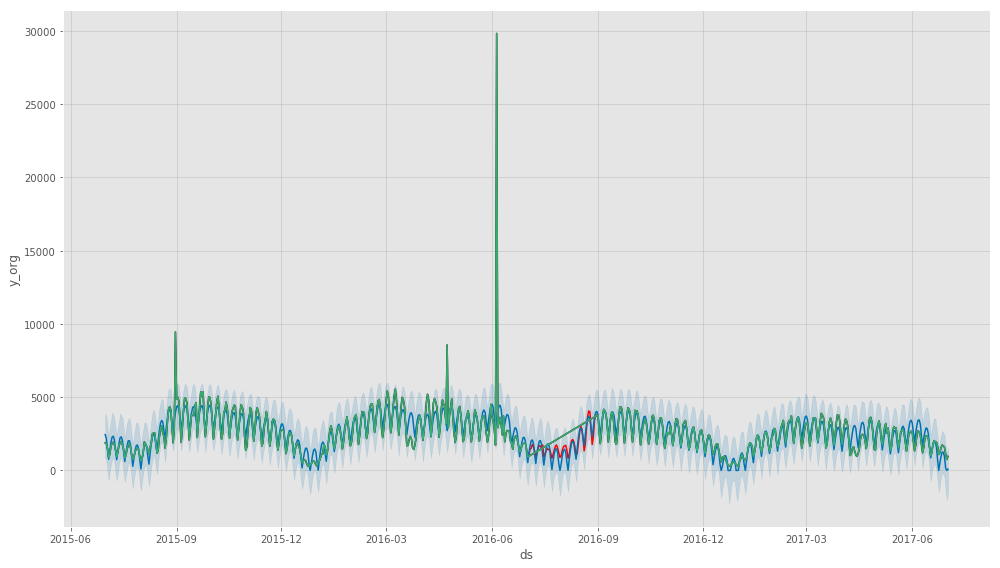

In [154]:
# worst
for row in df[filter_df2].sort_values(
    by='test_gain', ascending=True).iloc[20:30].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

page_index                                                              96212
v7ty_train                                                            27.0962
v7ty_val                                                              19.4936
v7t_train                                                             26.1385
v7t_val                                                               16.6107
Page                        Deforestación_es.wikipedia.org_mobile-web_all-...
median_pred_60                                                           2241
median_pred_120                                                          1455
prevYear_median_pred_60                                                  1805
prevYear_median_pred_120                                                 1196
smape_60_to_0                                                         79.6878
smape_120_to_60                                                       44.9582
prevYear_smape_60_to_0                                          

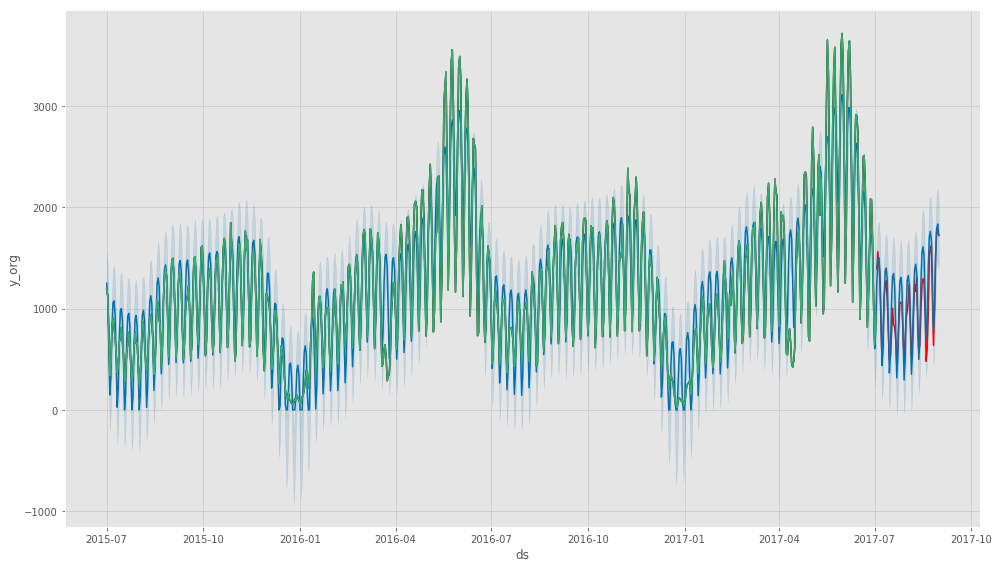

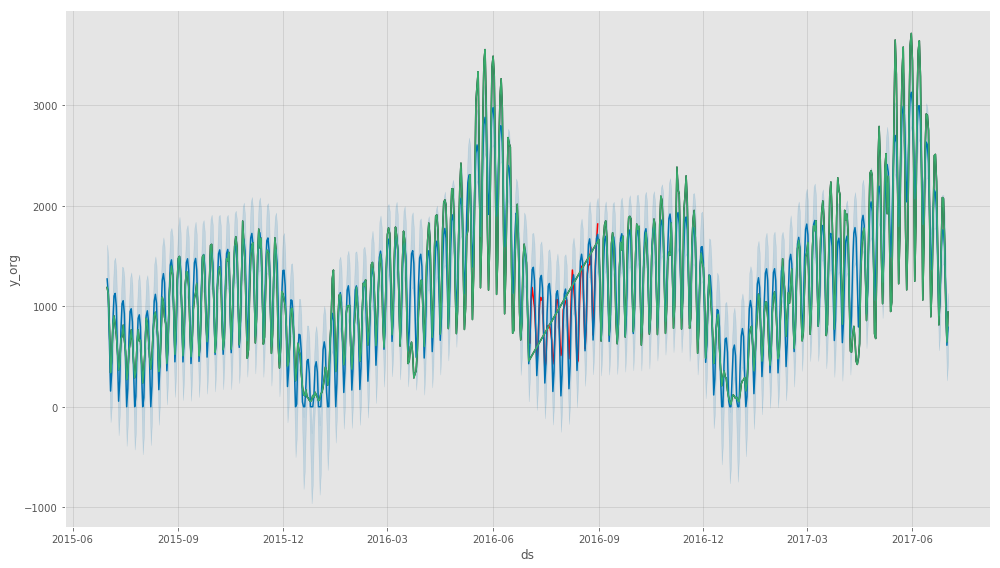

page_index                                                              23773
v7ty_train                                                            18.9174
v7ty_val                                                              25.7089
v7t_train                                                             18.6966
v7t_val                                                               39.6848
Page                        Cara_Delevingne_fr.wikipedia.org_all-access_al...
median_pred_60                                                           1050
median_pred_120                                                          1379
prevYear_median_pred_60                                                   909
prevYear_median_pred_120                                                 1339
smape_60_to_0                                                         102.081
smape_120_to_60                                                       28.1113
prevYear_smape_60_to_0                                          

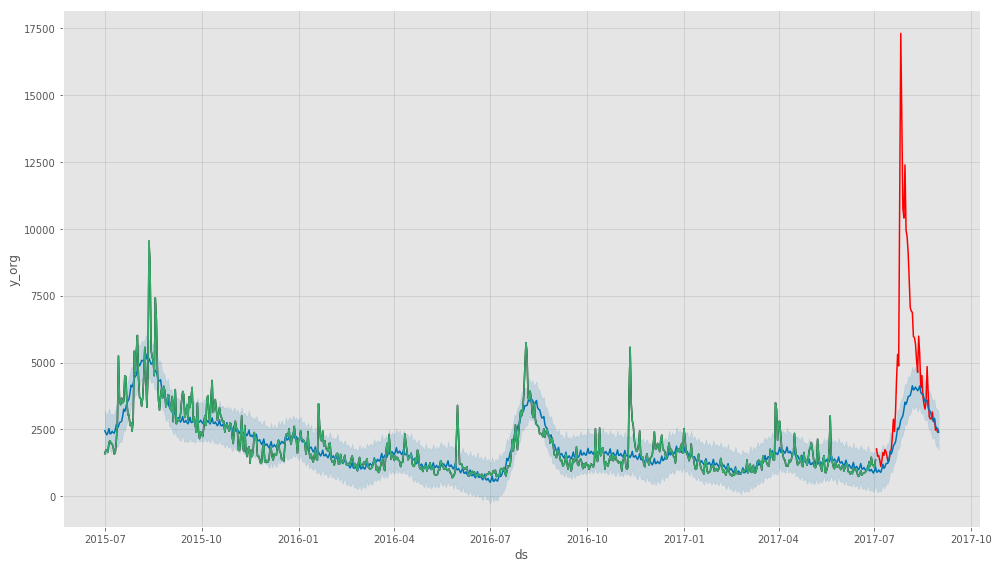

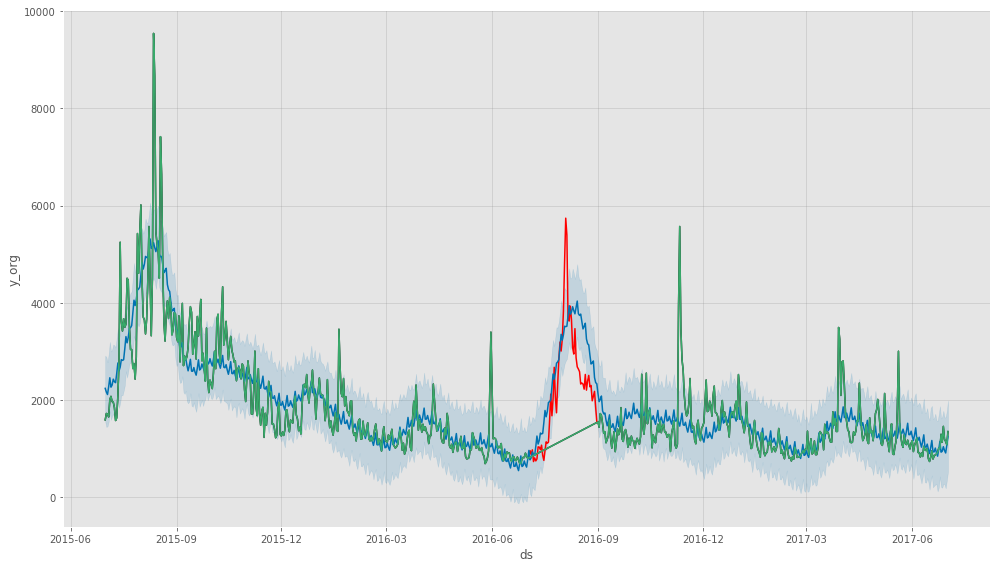

page_index                                                              92022
v7ty_train                                                            24.7341
v7ty_val                                                              69.9279
v7t_train                                                             25.2557
v7t_val                                                               39.0852
Page                        Juegos_tradicionales_es.wikipedia.org_all-acce...
median_pred_60                                                           2605
median_pred_120                                                          1464
prevYear_median_pred_60                                                  2309
prevYear_median_pred_120                                                 1506
smape_60_to_0                                                         101.278
smape_120_to_60                                                       59.4034
prevYear_smape_60_to_0                                          

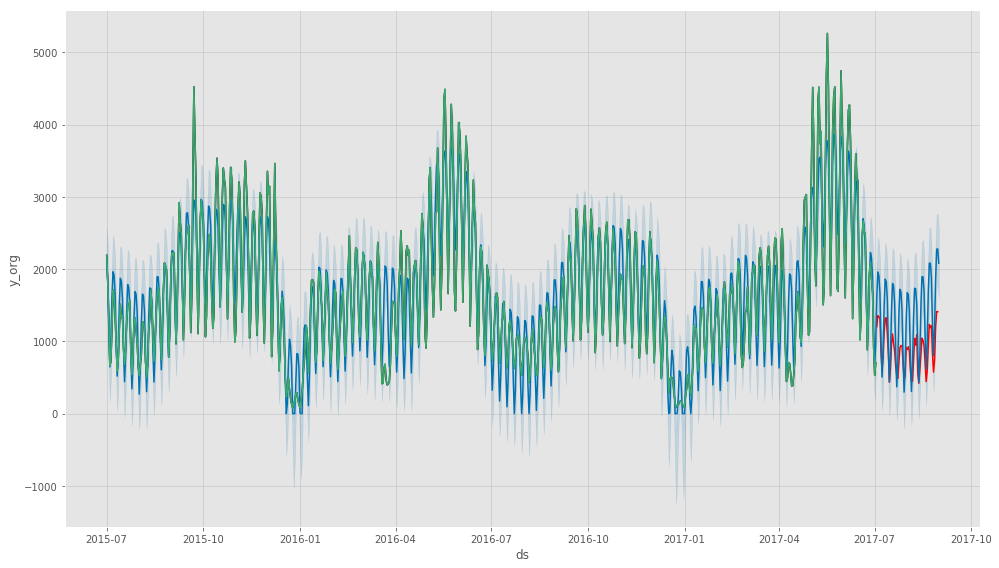

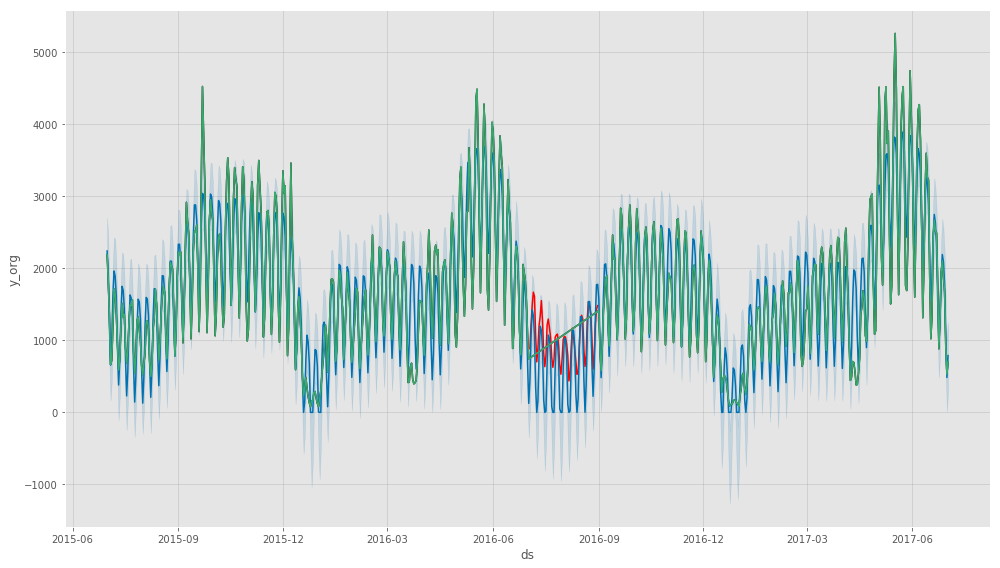

page_index                                                            97116
v7ty_train                                                          23.8438
v7ty_val                                                            30.2257
v7t_train                                                           23.3747
v7t_val                                                             19.7042
Page                        Polímero_es.wikipedia.org_mobile-web_all-agents
median_pred_60                                                         1626
median_pred_120                                                         946
prevYear_median_pred_60                                                1238
prevYear_median_pred_120                                                928
smape_60_to_0                                                        81.748
smape_120_to_60                                                     53.2347
prevYear_smape_60_to_0                                              72.0047
prevYear_sma

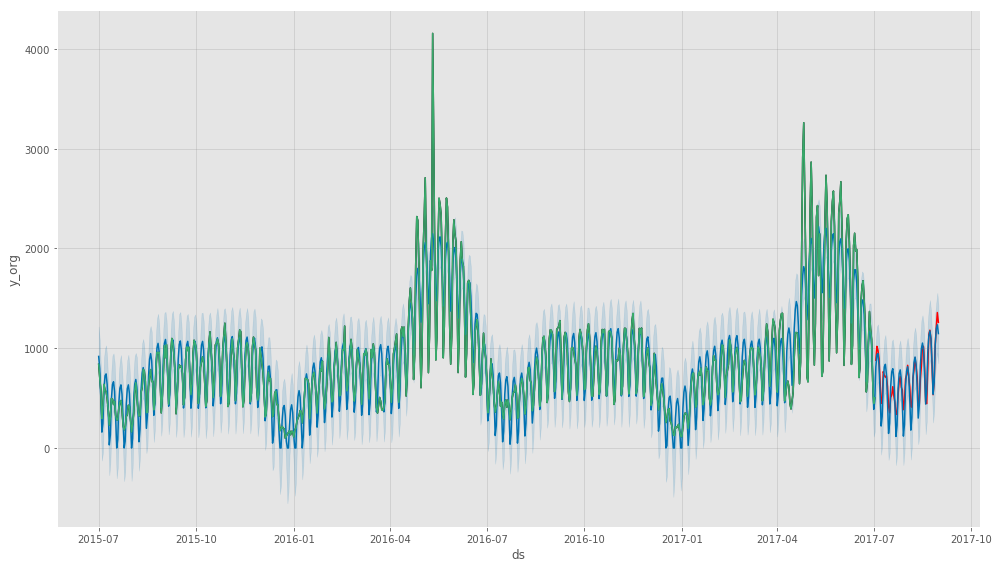

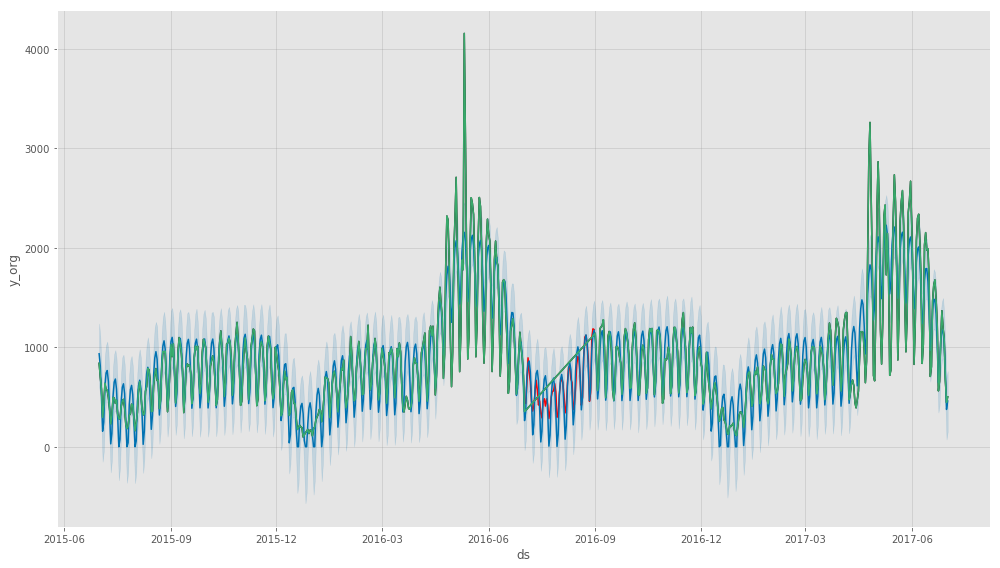

page_index                                                              51290
v7ty_train                                                            20.8671
v7ty_val                                                              37.2621
v7t_train                                                              21.024
v7t_val                                                               43.6348
Page                        Cara_Delevingne_fr.wikipedia.org_mobile-web_al...
median_pred_60                                                            595
median_pred_120                                                           807
prevYear_median_pred_60                                                   416
prevYear_median_pred_120                                                  614
smape_60_to_0                                                         105.595
smape_120_to_60                                                       33.1474
prevYear_smape_60_to_0                                          

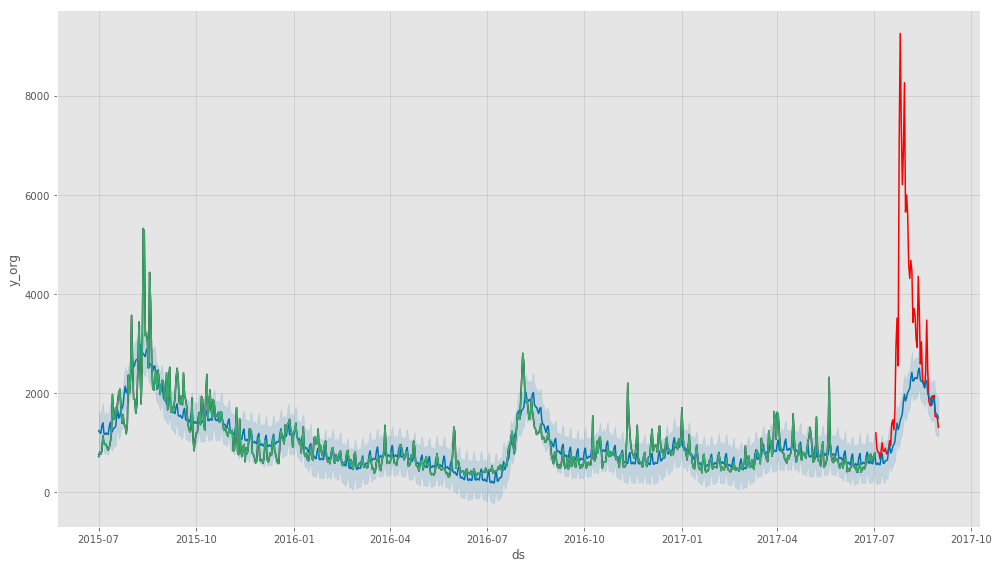

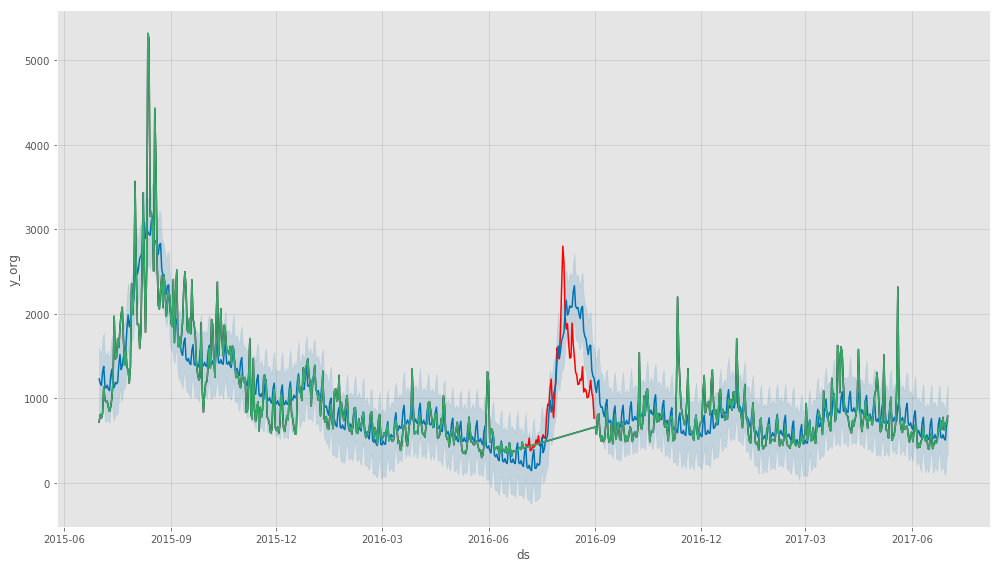

page_index                                                             69976
v7ty_train                                                           25.9572
v7ty_val                                                             22.2088
v7t_train                                                             24.645
v7t_val                                                              47.5576
Page                        Fertilizante_es.wikipedia.org_desktop_all-agents
median_pred_60                                                          1151
median_pred_120                                                          582
prevYear_median_pred_60                                                 1283
prevYear_median_pred_120                                                 419
smape_60_to_0                                                        109.434
smape_120_to_60                                                      58.3149
prevYear_smape_60_to_0                                               106.246

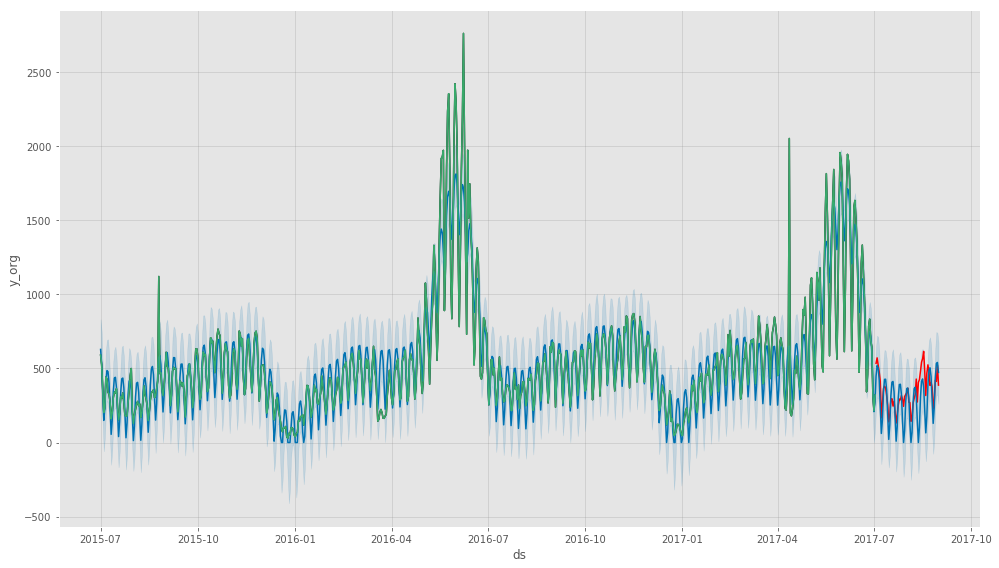

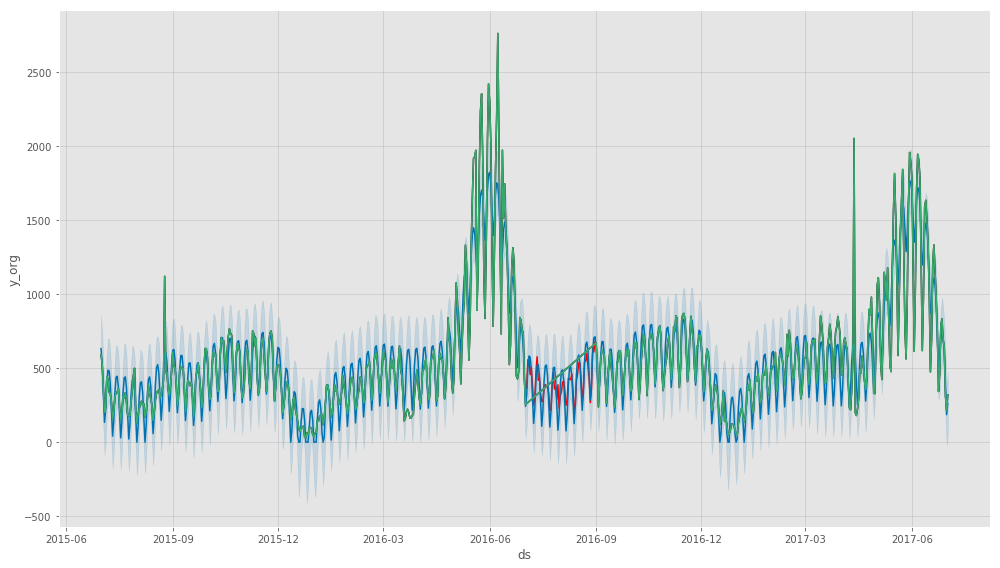

page_index                                                            114567
v7ty_train                                                            14.247
v7ty_val                                                             12.4087
v7t_train                                                            13.7766
v7t_val                                                              12.6149
Page                        Erdbeeren_de.wikipedia.org_mobile-web_all-agents
median_pred_60                                                          1118
median_pred_120                                                          730
prevYear_median_pred_60                                                 1284
prevYear_median_pred_120                                                 739
smape_60_to_0                                                        74.3317
smape_120_to_60                                                      45.2442
prevYear_smape_60_to_0                                                 81.73

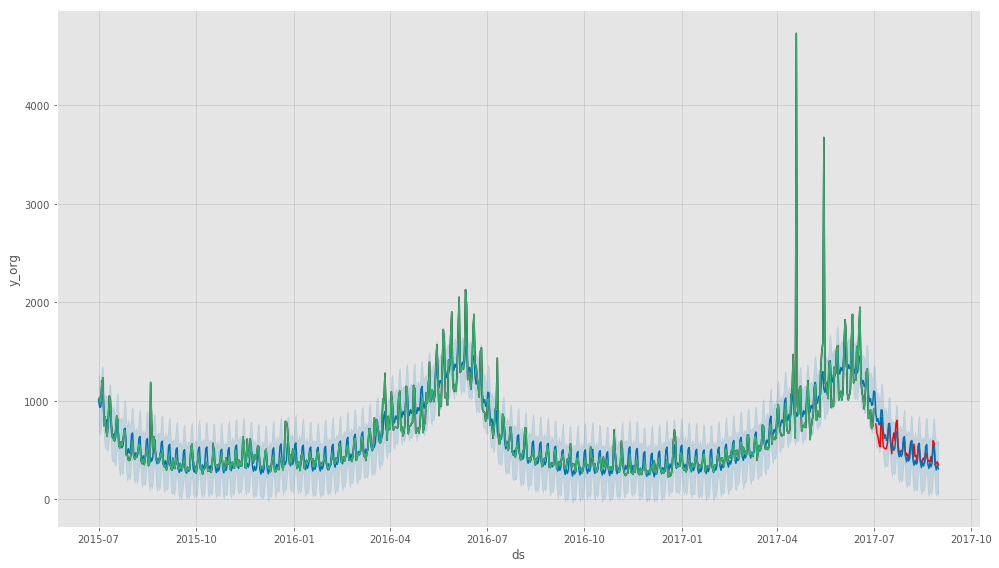

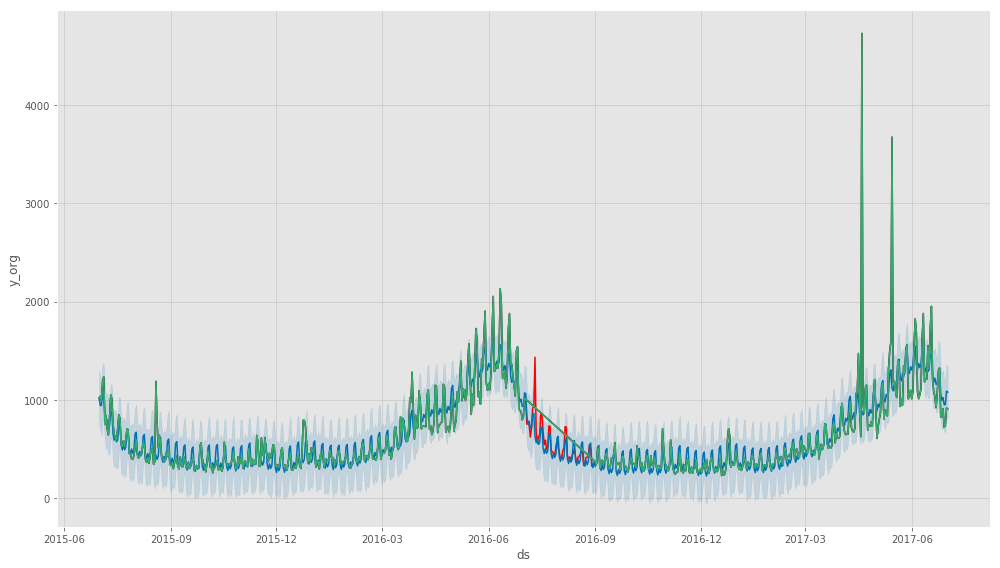

page_index                                                              98134
v7ty_train                                                            17.4634
v7ty_val                                                              15.2278
v7t_train                                                             16.8041
v7t_val                                                                16.365
Page                        Клещевой_энцефалит_ru.wikipedia.org_all-access...
median_pred_60                                                           1531
median_pred_120                                                           699
prevYear_median_pred_60                                                  1141
prevYear_median_pred_120                                                  861
smape_60_to_0                                                         77.8826
smape_120_to_60                                                       74.6379
prevYear_smape_60_to_0                                          

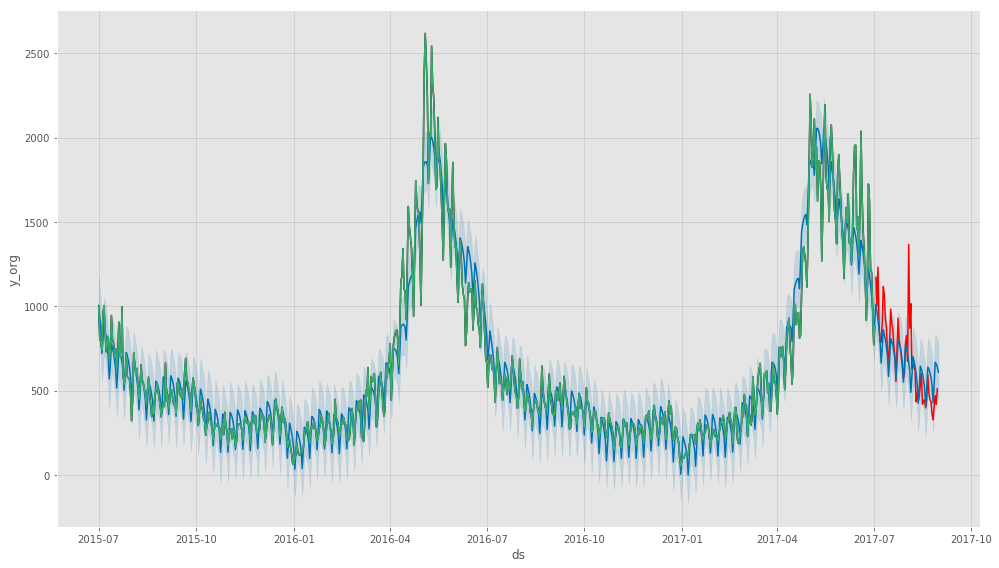

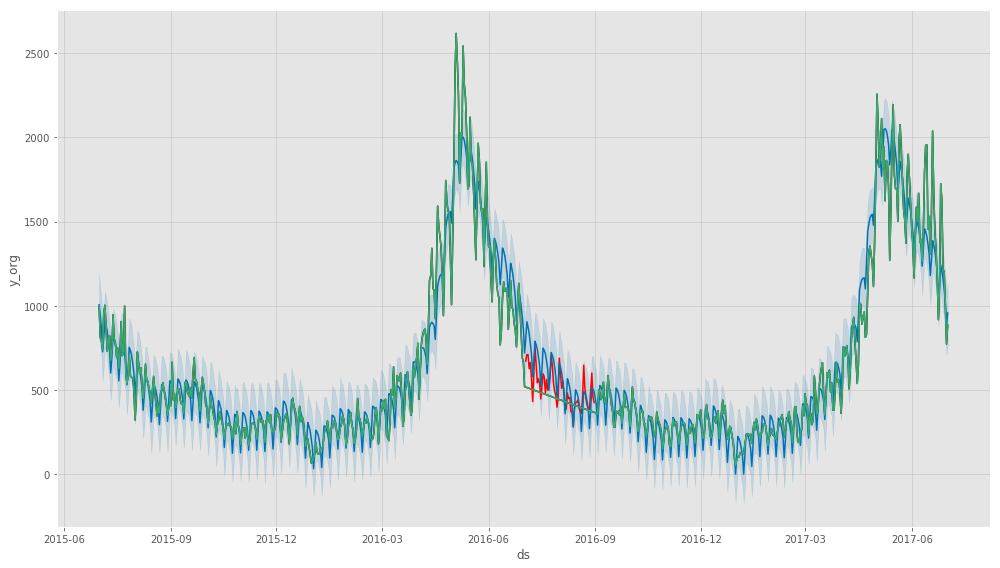

page_index                                                             95127
v7ty_train                                                           24.4782
v7ty_val                                                             22.5514
v7t_train                                                            23.9024
v7t_val                                                              14.8419
Page                        Reciclaje_es.wikipedia.org_mobile-web_all-agents
median_pred_60                                                          2245
median_pred_120                                                         1424
prevYear_median_pred_60                                                 1883
prevYear_median_pred_120                                                1355
smape_60_to_0                                                        75.9349
smape_120_to_60                                                       45.848
prevYear_smape_60_to_0                                               72.3248

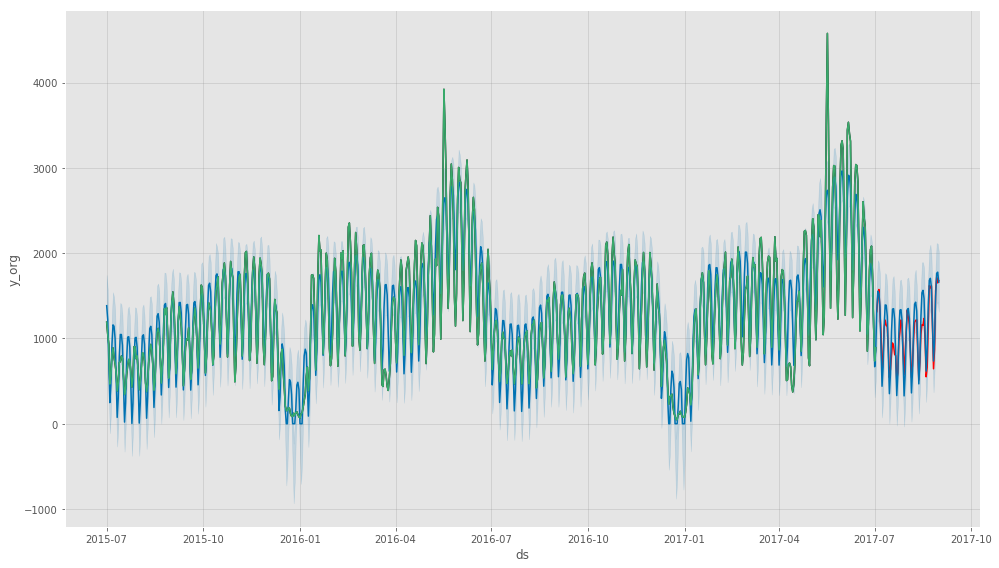

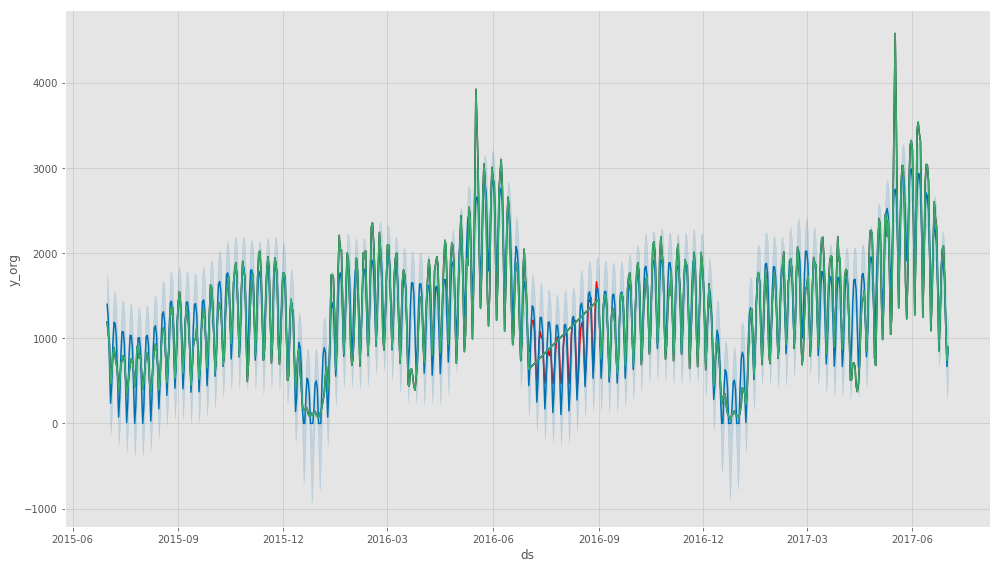

page_index                                                              53527
v7ty_train                                                            24.2074
v7ty_val                                                              12.4841
v7t_train                                                              23.226
v7t_val                                                               13.3926
Page                        Dune_du_Pilat_fr.wikipedia.org_mobile-web_all-...
median_pred_60                                                            473
median_pred_120                                                           394
prevYear_median_pred_60                                                   353
prevYear_median_pred_120                                                  339
smape_60_to_0                                                          74.089
smape_120_to_60                                                       29.3484
prevYear_smape_60_to_0                                          

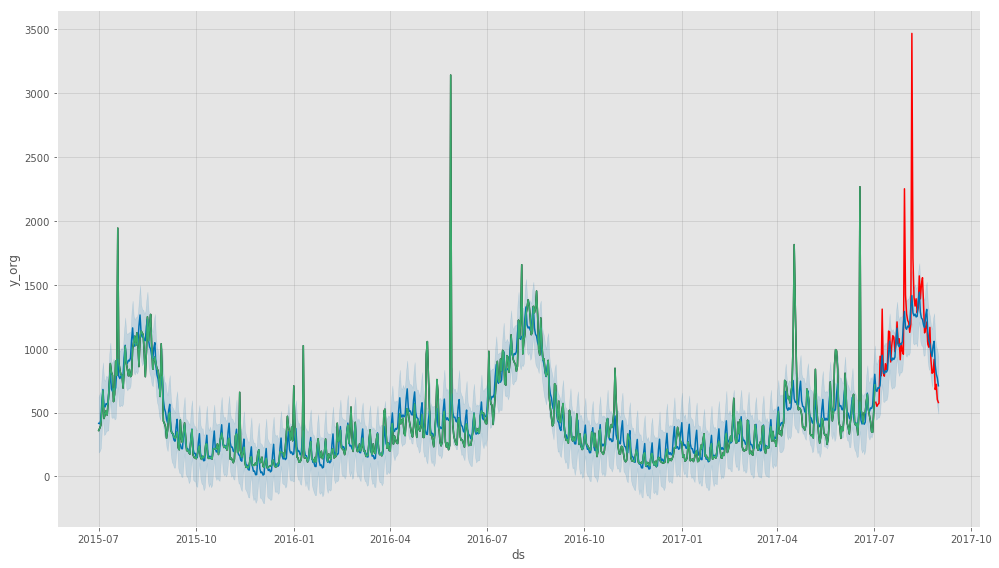

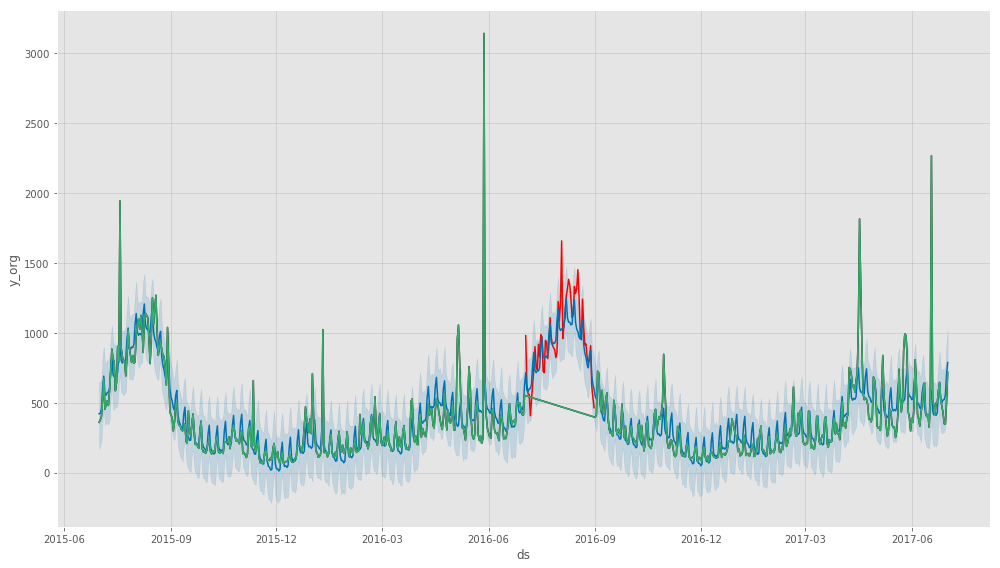

In [153]:
# best
for row in df[filter_df2].sort_values(
    by='test_gain', ascending=False).iloc[20:30].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

# Saving Results 

In [186]:
# save the pages and val scores
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather(
    #'../data/prophet/results/proph_v7_vals.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-186-199ed2d99082>, line 3)

In [187]:
# save the pages and val scores
# need to grab yhat here I think
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    #'../data/prophet/results/proph_v7_preds.f')

SyntaxError: unexpected EOF while parsing (<ipython-input-187-24f78de871a1>, line 4)